# Main anaysis

### Setup

#### Imports

In [85]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

#### Overrides

In [106]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma='log10(0.5)'",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.imprecise_imitation_gamma='np.log(0.5)'",
    # "simulation.dynamics.max_its=1000", # important to specify maxits
    "seed=0",
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

#### Helper function to filter data by config data

In [107]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma


    imprecise_imitation_gamma = df["imprecise_imitation_gamma"].isin([curve_metadata.meaning_dist_gamma, np.nan]) # allows curve, and constraints to be the same as curve.

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & imprecise_imitation_gamma]

    return df_subsetted

#### Load data

In [108]:
all_data_fp = "../../analysis_data/all_data.csv"
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_95544/1048885480.py:2: DtypeWarning: Columns (15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,sender_delta,receiver_delta,min_epsilon,min_beta
0,1.526090e+00,1.270097,0.641931,2.278652,[0.0054146544510602634],0.012748,1.095495,0.0,simulation,NaN,...,1.0,0,replicator_diffusion,0,-8.0,6.0,NaN,NaN,NaN,NaN
1,0.000000e+00,0.000000,1.912028,16.399997,NaN,NaN,NaN,1.0,trajectory,0.0,...,1.0,0,replicator_diffusion,0,-8.0,6.0,NaN,NaN,NaN,NaN
2,0.000000e+00,0.000000,1.912028,16.330831,NaN,NaN,NaN,1.0,trajectory,1.0,...,1.0,0,replicator_diffusion,0,-8.0,6.0,NaN,NaN,NaN,NaN
3,0.000000e+00,0.000000,1.912028,16.278492,NaN,NaN,NaN,1.0,trajectory,2.0,...,1.0,0,replicator_diffusion,0,-8.0,6.0,NaN,NaN,NaN,NaN
4,8.881784e-16,0.000000,1.912028,16.236625,NaN,NaN,NaN,1.0,trajectory,3.0,...,1.0,0,replicator_diffusion,0,-8.0,6.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125954,6.641519e+00,NaN,NaN,0.000155,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125955,6.641784e+00,NaN,NaN,0.000136,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125956,6.642023e+00,NaN,NaN,0.000118,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125957,6.642238e+00,NaN,NaN,0.000103,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filter

In [109]:
df = get_df_subsetted_by_meaning_dists(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,sender_delta,receiver_delta,min_epsilon,min_beta
107902,4.027770,3.774466,28.128707,6.361849,NaN,NaN,NaN,0.0,simulation,NaN,...,0,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,0.163581,0.176864,0.000965,1.437688
107903,5.758603,3.752014,35.886008,1779.352501,NaN,NaN,NaN,1.0,trajectory,1.0,...,0,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,173.649804,183.127410,0.742313,5.178137
107904,3.666112,3.397727,36.287339,44.250905,NaN,NaN,NaN,1.0,trajectory,2.0,...,0,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,17.547458,47.581877,0.108370,1.261809
107905,3.609271,3.393595,34.983539,37.847397,NaN,NaN,NaN,1.0,trajectory,3.0,...,0,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,10.748501,21.591260,0.067147,1.240704
107906,3.624934,3.422218,34.249095,31.582446,NaN,NaN,NaN,1.0,trajectory,4.0,...,0,log10(0.5),imprecise_conditional_imitation,log10(0.5),2.0,0.0,10.081795,13.065608,0.051092,1.247739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125954,6.641519,NaN,NaN,0.000155,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125955,6.641784,NaN,NaN,0.000136,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125956,6.642023,NaN,NaN,0.000118,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125957,6.642238,NaN,NaN,0.000103,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,log10(0.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# Edge cases where discriminative_need_gamma and meaning_dist_gamma are str types
for col in [
    "discriminative_need_gamma",
    "meaning_dist_gamma",
    "imprecise_imitation_gamma",
]:
    df[col].replace("log10(0.5)", np.log10(0.5), inplace=True)
    df[col] = df[col].astype(float)

Separate out observations into curves and simulation points

In [111]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

Transform log params

In [112]:
df_final_points["discriminative_need_gamma"] = 10 ** df_final_points["discriminative_need_gamma"]
df_final_points["imprecise_imitation_gamma"] = 10 ** df_final_points["imprecise_imitation_gamma"]

Restrict dynamics

In [113]:
df_final_points = df_final_points[df_final_points["dynamics"] == "imprecise_conditional_imitation"]

How does discriminative_need_gamma range?

In [114]:
df_final_points.discriminative_need_gamma.unique()

array([1.e+00, 1.e+01, 1.e-01, 5.e-01, 1.e-03, 1.e+03, 1.e+02, 1.e-02])

### Visualize

In [115]:
# Make sure complexity max is np.log2(100)
df_ib_bound.complexity.max()
np.log2(100) #TODO: run overnight with more betas.

6.643856189774724

#### First visualize all data, across initializations and seeds

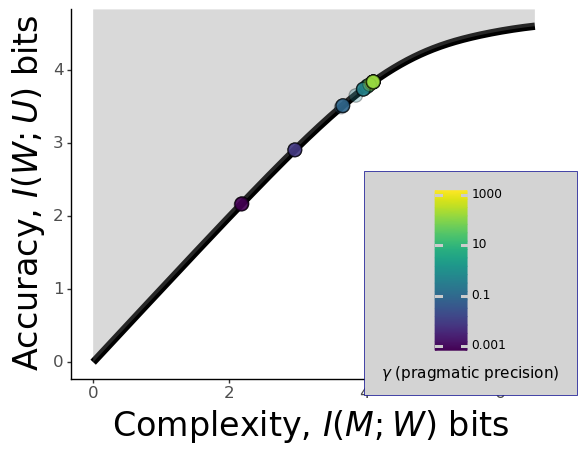

In [116]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            ),
        alpha=0.3,
        size=5,
    )
    + pn.labs(fill="$\\gamma$ (pragmatic precision)")
    # + pn.labs(fill="$\\alpha$ (perceptual certainty)")    
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    ) 
)
print(plot)

#### Hack: mock viridis

In [124]:
# https://waldyrious.net/viridis-palette-generator/
fill_values_dict = {
    str(k): v for k, v in {
        "0.001": "#440154",
        "0.01": "#46327e",
        "0.1": "#365c8d",
        "0.5": "#277f8e",
        "1.0": "#1fa187",
        "10.0": "#4ac16d",
        "100.0" : "#a0da39",
        "1000.0": "#fde725", 
    }.items() }

#### Distribution of efficiency loss across converged emergent systems

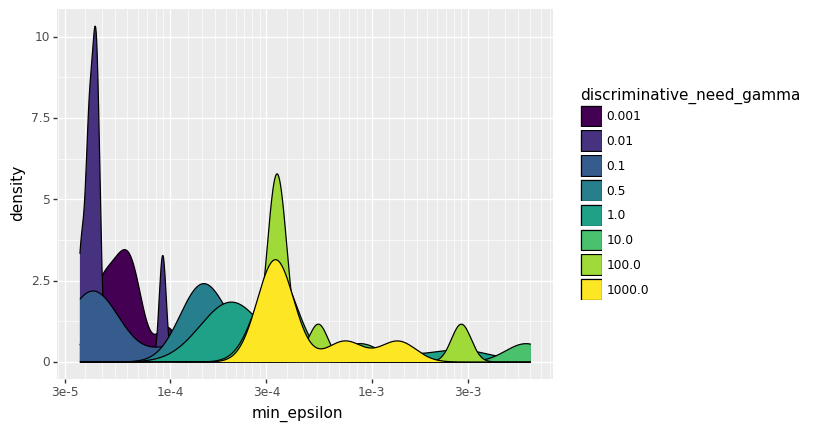

<ggplot: (360798764)>

In [125]:
df_final_points_disc = df_final_points.copy()
df_final_points_disc["discriminative_need_gamma"] = df_final_points_disc["discriminative_need_gamma"].astype(str)

(
    pn.ggplot(
        df_final_points_disc,
        pn.aes(
            x="min_epsilon",
            fill="discriminative_need_gamma",
        )
    )
    + pn.scale_fill_manual(values = fill_values_dict)
    + pn.geom_density()
    + pn.scale_x_log10()
)

#### Trajectories of efficiency loss

Filter

In [126]:
gamma = 'discriminative_need_gamma'

df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["round"]

df_traj_analysis = df_traj_points.copy()

df_traj_analysis = df_traj_analysis[["iteration", "min_distance_to_curve", "min_epsilon", "min_beta", gamma, "population_init_gamma", "complexity", "accuracy"]]

df_traj_analysis[gamma] = 10 ** df_traj_analysis[gamma]
df_traj_analysis["population_init_gamma"] = 10 ** df_traj_analysis["population_init_gamma"]

df_traj_analysis["discriminative_need_gamma"] = df_traj_analysis["discriminative_need_gamma"].astype(str)

df_traj_analysis

,iteration,min_distance_to_curve,min_epsilon,min_beta,discriminative_need_gamma,population_init_gamma,complexity,accuracy
107903,1.0,0.727310,0.742313,5.178137,1.0,100.00,5.758603,3.752014
107904,2.0,0.085619,0.108370,1.261809,1.0,100.00,3.666112,3.397727
107905,3.0,0.052678,0.067147,1.240704,1.0,100.00,3.609271,3.393595
107906,4.0,0.039961,0.051092,1.247739,1.0,100.00,3.624934,3.422218
107907,5.0,0.034120,0.041215,1.268844,1.0,100.00,3.671080,3.468818
...,...,...,...,...,...,...,...,...
118704,195.0,0.000953,0.000044,1.097538,0.01,0.01,2.972381,2.910698
118705,197.0,0.000977,0.000044,1.097538,0.01,0.01,2.972364,2.910682
118706,198.0,0.000988,0.000044,1.097538,0.01,0.01,2.972355,2.910675
118707,199.0,0.000999,0.000044,1.097538,0.01,0.01,2.972347,2.910667


In [127]:
# Ensure iteration max is the same as max_its specified by game config
df_traj_analysis.iteration.max()

200.0

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 15 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/guides/guide_colorbar.py:72: PlotnineWarning: colorbar guide needs continuous scales


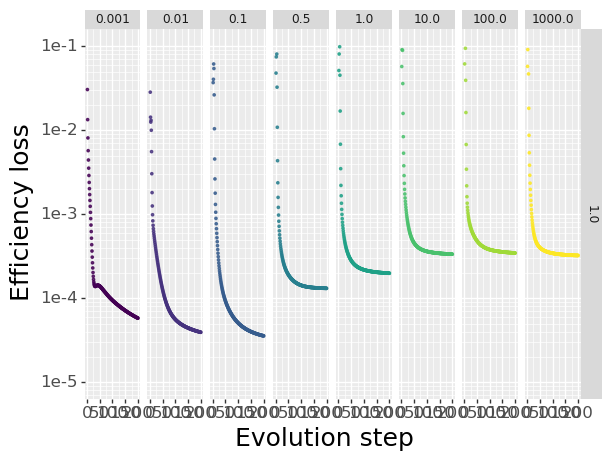

In [129]:
plot = (
    pn.ggplot(
        # df_traj_analysis[df_traj_analysis["population_init_gamma"] == 1.],
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_epsilon", 
        ),
    )
    + pn.geom_point(
        pn.aes(color="discriminative_need_gamma"),
        size=0.5,
        alpha=0.8,
        )
    + pn.scale_color_manual(values = fill_values_dict)
    + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("Efficiency loss")
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=18),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.7, 0.6),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    + pn.guides(
        color = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    )
    + pn.scale_y_continuous(
        trans='log10', 
        limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
)
print(plot)